### Pipeline task 8 for Kaggle:

Imports 

In [61]:
# Imports
import os
import shutil
import numpy as np
import cv2
import random
import tensorflow as tf 
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, UpSampling2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import classification_report
from keras import backend as K
from keras import layers, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.morphology import remove_small_objects
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
import networkx as nx
from patchify import patchify, unpatchify
import pandas as pd

### Step 1: Load the images from Kaggle:


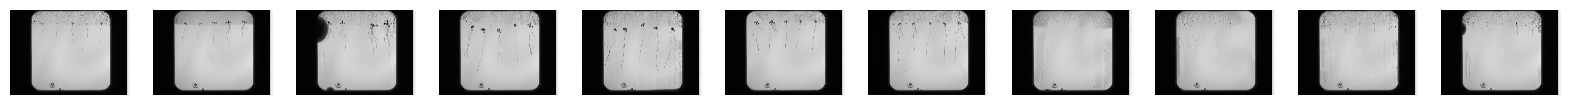

In [62]:
import os
from PIL import Image
import matplotlib.pyplot as plt


def load_and_plot_images_from_directory(dataset_directory):
    if not os.path.exists(dataset_directory):
        raise FileNotFoundError(f"Directory {dataset_directory} does not exist.")

    supported_extensions = {".png", ".jpg", ".jpeg", ".bmp", ".tif"}
    image_paths = [
        os.path.join(dataset_directory, file)
        for file in os.listdir(dataset_directory)
        if os.path.splitext(file)[1].lower() in supported_extensions
    ]

    if not image_paths:
        raise FileNotFoundError(
            f"No supported image files found in {dataset_directory}."
        )

    images = [Image.open(path) for path in image_paths]

    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis("off")
    plt.show()

    return images


dataset_directory = r"kaggle"
images = load_and_plot_images_from_directory(dataset_directory)

#### Step 2: loading functions

In [63]:
# Function to load the U-Net model from Task 5
def load_unet_model(model_path):
    model = load_model(model_path, custom_objects={'f1': f1})
    return model

# Function to crop the Petri dish (ROI)
def petri_dish_crop(image):
    
    # Reading the given image
    img = cv2.imread(image,0)

    # Applying blur using GaussianBlur
    blur = cv2.GaussianBlur(img, (3, 3), 0)

    # Apply thresholding
    _, thresh = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY, cv2.THRESH_OTSU)
    # _, thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # Apply morphological operations to clean up noise
    kernel = np.ones((7, 7), np.uint8)
    thresh = cv2.dilate(thresh, kernel, iterations=3)  # Dilation to connect fragmented parts
    thresh = cv2.erode(thresh, kernel, iterations=4)  # Erosion to remove small noise
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # The largest contour
    contour = max(contours, key=cv2.contourArea)

    # Get the bounding rectangle of the contour which will be cut out from the image
    x, y, w, h = cv2.boundingRect(contour)

    # Crop the petri dish
    crop = img[y:y+h, x:x+w]

    return crop

# Function to pad the image to the patch size
def padder(image, patch_size):
    if image.shape[0] < patch_size or image.shape[1] < patch_size:
        return np.zeros((patch_size, patch_size), dtype=image.dtype)  # Return blank padded image

    h, w = image.shape[:2]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding
    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(
        image, top_padding, bottom_padding, left_padding, right_padding,
        cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )
    print(padded_image.shape)
    return padded_image
    

def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        FN = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
        recall = TP / (TP + FN + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        FP = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
        precision = TP / (TP + FP + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Function for root system architecture (RSA) extraction


#### Second step: process images

In [64]:
# Function for root system architecture (RSA) extraction


def extract_rsa(mask):
    mask = (mask > 0).astype(np.uint8)
    # Get the dimensions of the mask
    height, width = mask.shape

    # Divide the image into five equal parts vertically
    part_width = width // 5

    # Create a list to store the image parts
    image_parts_vertical = []

    # Split the mask into 5 parts
    for i in range(5):
        start_col = i * part_width
        end_col = (i + 1) * part_width if i < 4 else width
        part = mask[:, start_col:end_col]
        image_parts_vertical.append(part)

    # Define the minimum area threshold
    min_area_threshold = 200

    processed_parts = []

    # Process each split image
    for i, part in enumerate(image_parts_vertical):
        # Apply thresholding to ensure binary mask
        _, binary_mask = cv2.threshold(
            part, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )

        # Find contours in the binary mask
        contours, _ = cv2.findContours(
            binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Create a blank mask for contours
        contour_mask = np.zeros_like(part, dtype=np.uint8)

        # Check if any contours are found
        if contours:
            # Loop through all contours and filter by area threshold
            for contour in contours:
                contour_area = cv2.contourArea(contour)
                if contour_area > min_area_threshold:
                    # Draw the valid contours on the mask
                    cv2.drawContours(
                        contour_mask, [contour], -1, 255, thickness=cv2.FILLED
                    )

        processed_parts.append(contour_mask)

    return processed_parts


# Function to calculate the length of the longest primary root
def measure_root(plant):

    # Ensure the plant mask is binary and 2D
    plant = np.array(plant, dtype=np.uint8)
    if plant.ndim != 2 or np.max(plant) == 0:
        print("Warning: Empty mask or invalid input detected.")
        return None, None, None, 0  # Return 0 for empty masks

    # Skeletonize the binary image
    skeletonized_plant = skeletonize(plant)
    if np.max(skeletonized_plant) == 0:
        print("Warning: No skeleton detected.")
        return None, None, None, 0  # Return 0 for empty skeletons

    # Create a skeleton object using skan
    try:
        skeleton_object = Skeleton(skeletonized_plant)
        branch_data = summarize(skeleton_object)

        # Convert skan output to a NetworkX graph
        G = nx.from_pandas_edgelist(
            branch_data,
            source="node-id-src",
            target="node-id-dst",
            edge_attr="branch-distance",
        )

        # Find the longest path in the graph
        connected_components = list(nx.connected_components(G))
        longest_path_len = 0
        longest_path = None

        for component in connected_components:
            subgraph = G.subgraph(component)
            nodes = list(subgraph.nodes)
            for i, src in enumerate(nodes):
                for dst in nodes[i + 1 :]:
                    try:
                        path_len = nx.dijkstra_path_length(
                            subgraph, src, dst, weight="branch-distance"
                        )
                        if path_len > longest_path_len:
                            longest_path_len = path_len
                            longest_path = nx.dijkstra_path(
                                subgraph, src, dst, weight="branch-distance"
                            )
                    except nx.NetworkXNoPath:
                        continue

        return branch_data, G, longest_path, longest_path_len

    except Exception as e:
        print(f"Error processing skeleton: {e}")
        return None, None, None, 0


def refine_mask(mask, kernel_size=5, iterations=3):

    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply morphological closing (dilation followed by erosion)
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    # Remove small objects or noise
    cleaned_mask = remove_small_objects(
        closed_mask > 0, min_size=50, connectivity=2
    ).astype(np.uint8)

    return (cleaned_mask * 255).astype(np.uint8)

### Step 3: The freaking pipeline:

(2816, 2816)
4/4 [==============================] - 1s 211ms/step


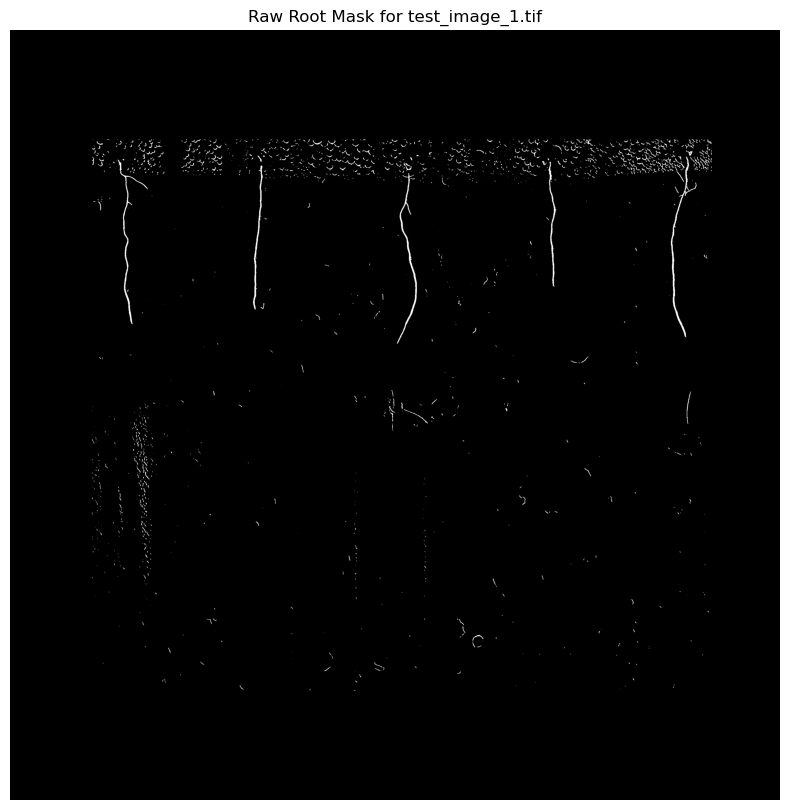

C:\Users\victo\AppData\Local\Temp\ipykernel_29768\3132472619.py:76: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  branch_data = summarize(skeleton_object)


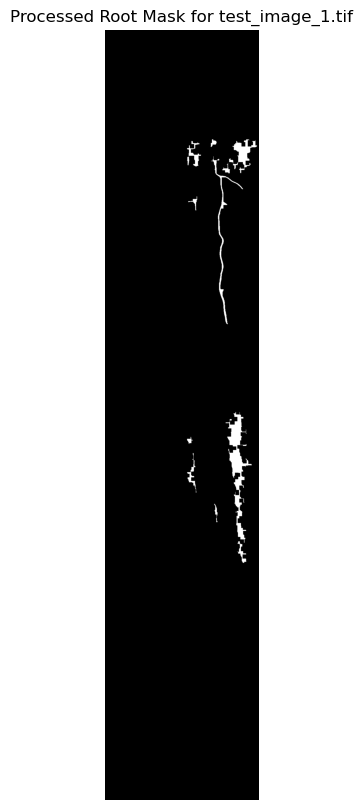

Plant ID: test_image_1_plant_1, Length: 677.3330444827411


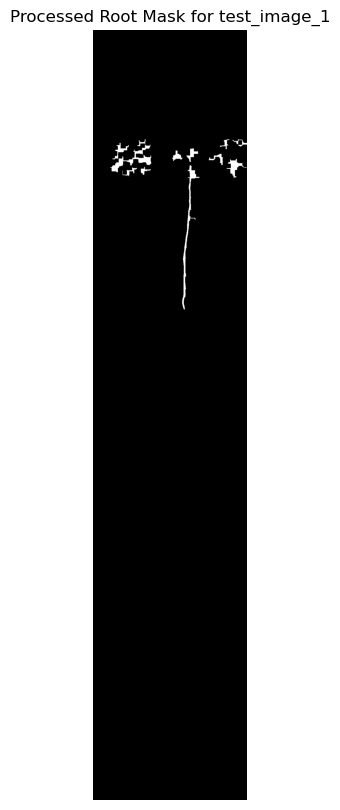

Plant ID: test_image_1_plant_2, Length: 552.2670273047589


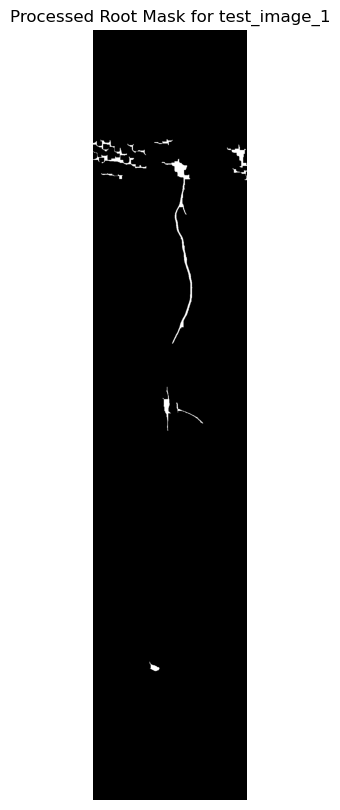

Plant ID: test_image_1_plant_3, Length: 801.0437226013964


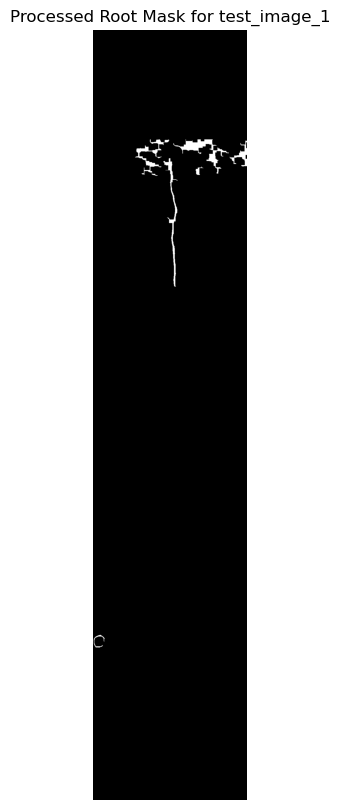

Plant ID: test_image_1_plant_4, Length: 504.33809511662446


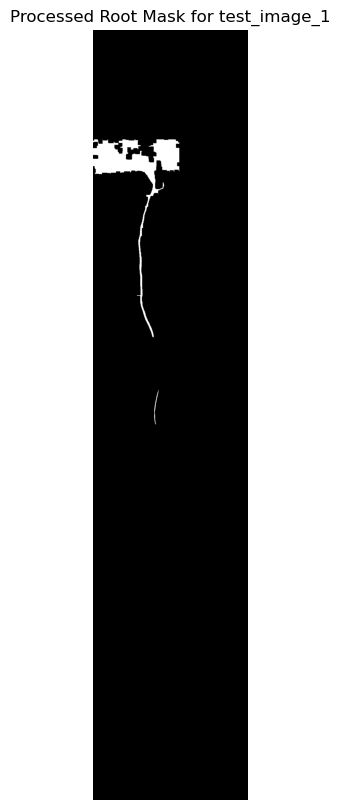

Plant ID: test_image_1_plant_5, Length: 955.8427124746192
(2816, 2816)
4/4 [==============================] - 1s 171ms/step


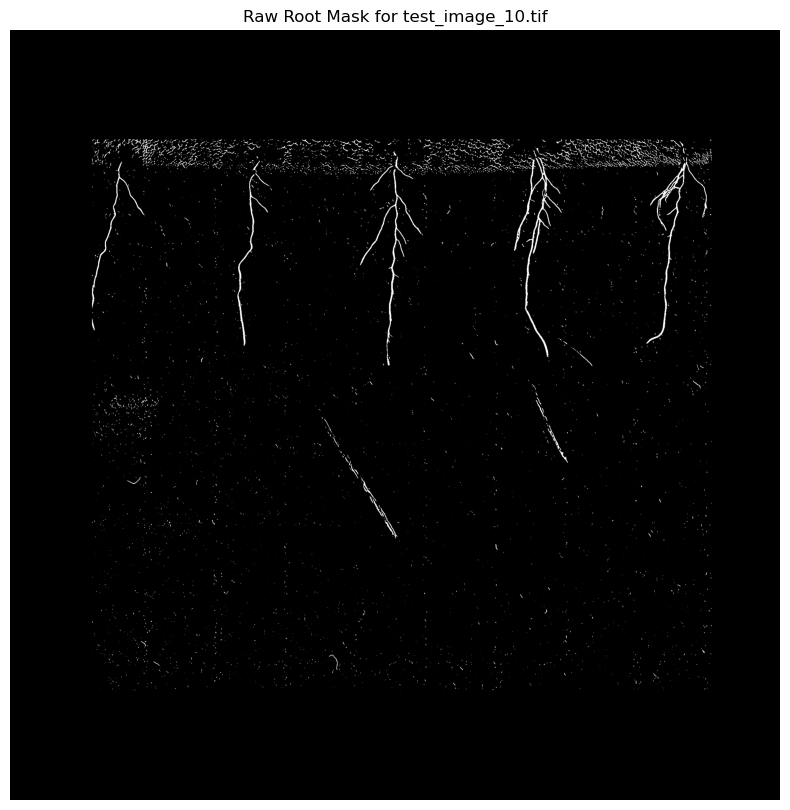

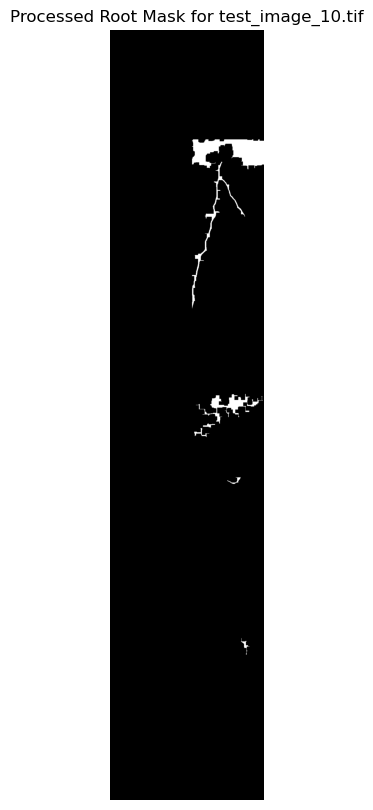

Plant ID: test_image_10_plant_1, Length: 717.6295090390227


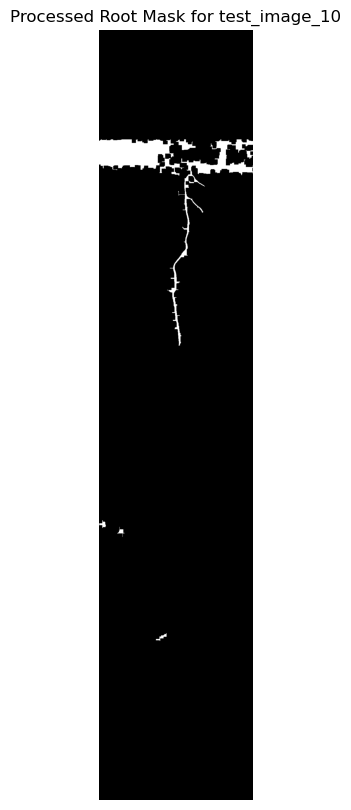

Plant ID: test_image_10_plant_2, Length: 1075.457936163769


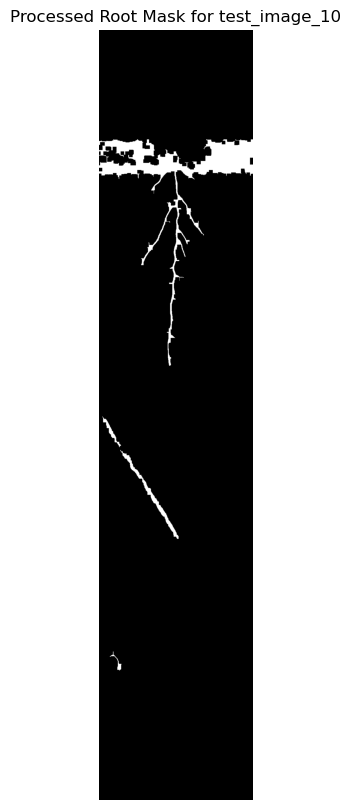

Plant ID: test_image_10_plant_3, Length: 1193.4284989122457


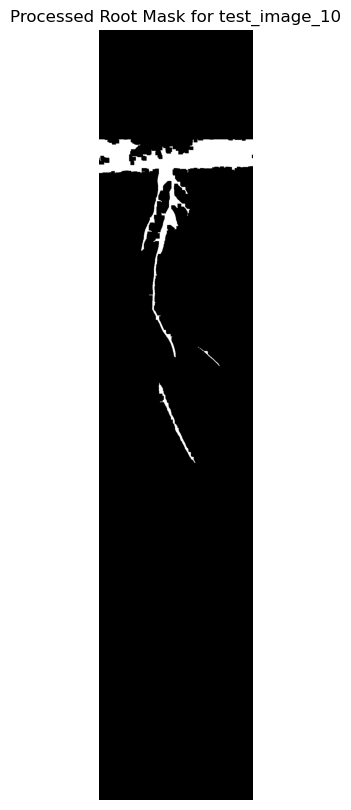

Plant ID: test_image_10_plant_4, Length: 1152.9676041556465


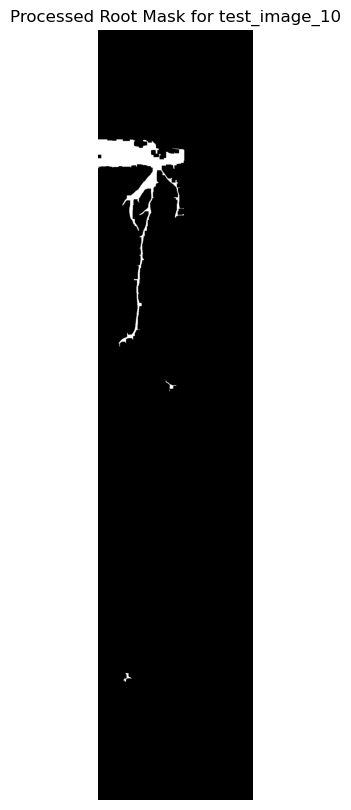

Plant ID: test_image_10_plant_5, Length: 1022.4406922210655
(2816, 2816)
4/4 [==============================] - 1s 162ms/step


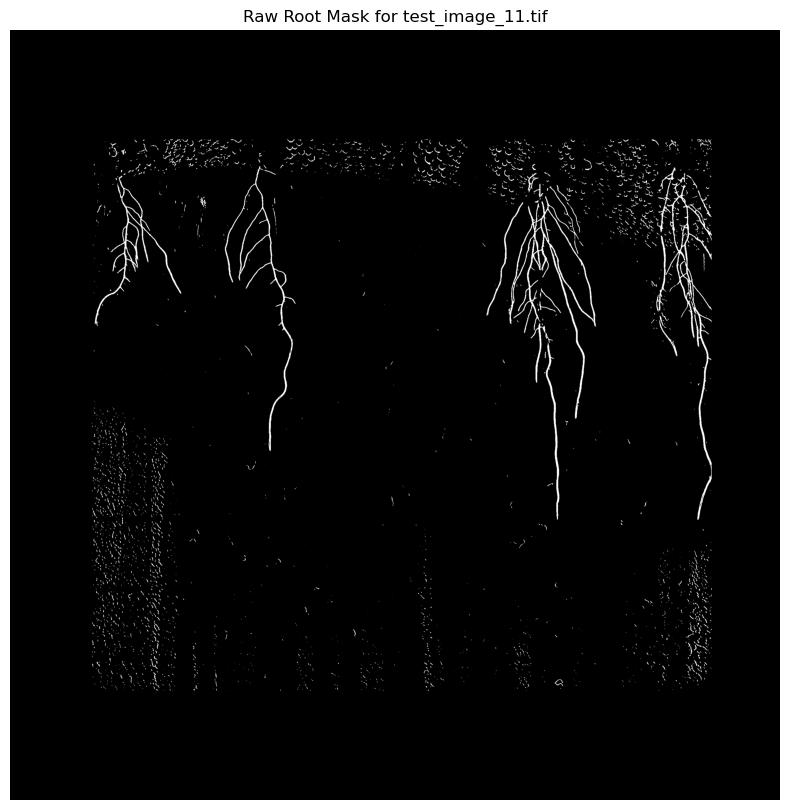

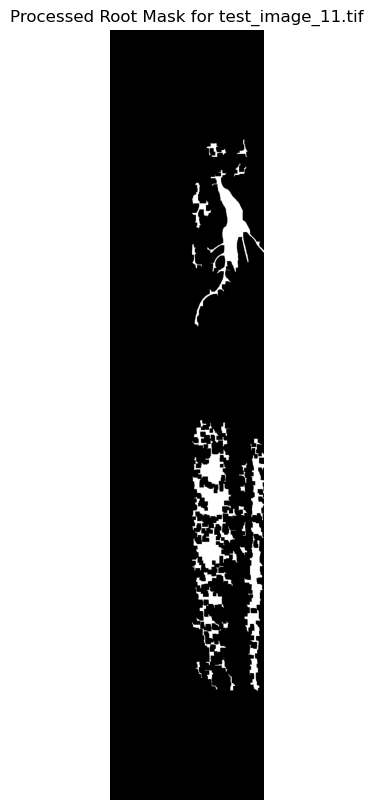

Plant ID: test_image_11_plant_1, Length: 885.0559159102155


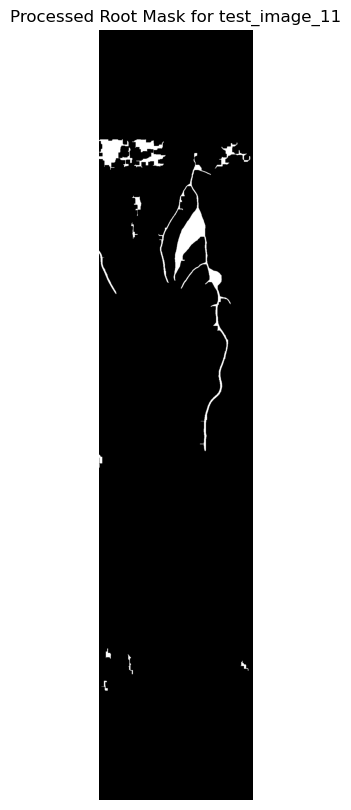

Plant ID: test_image_11_plant_2, Length: 1524.2295808265233


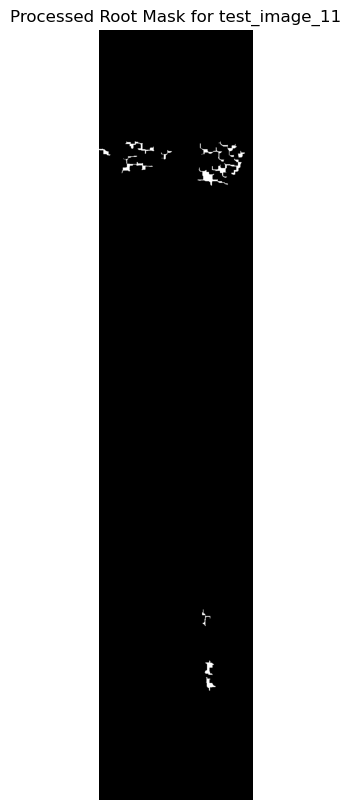

Plant ID: test_image_11_plant_3, Length: 168.5685424949238


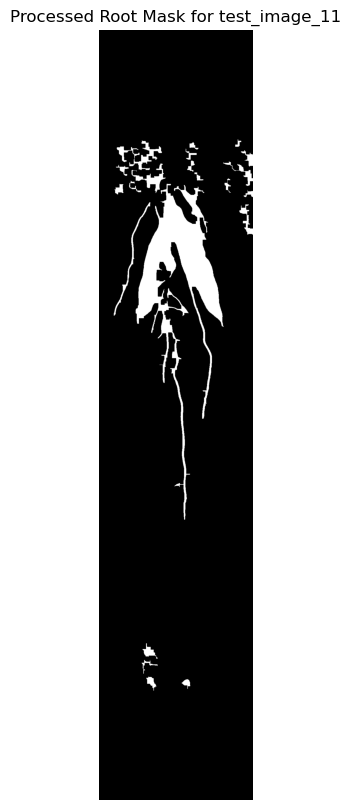

Plant ID: test_image_11_plant_4, Length: 2027.0407640085664


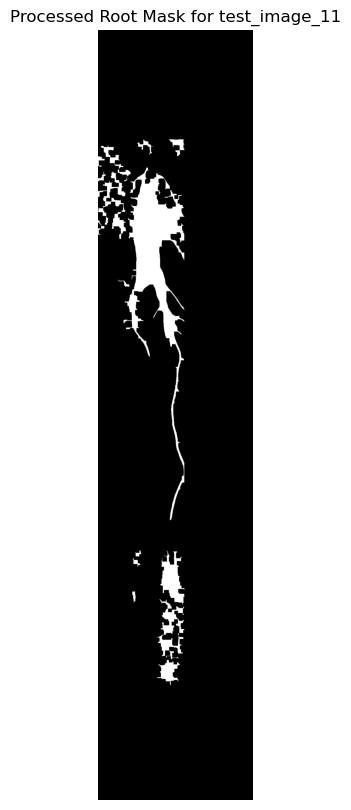

Plant ID: test_image_11_plant_5, Length: 1483.991990773287
(2816, 2816)
4/4 [==============================] - 1s 188ms/step


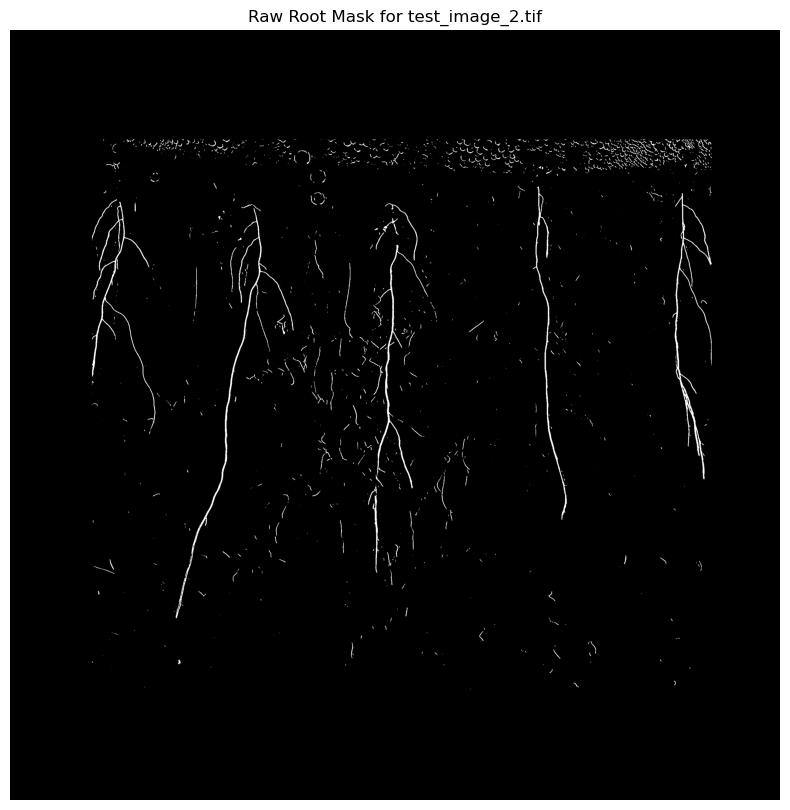

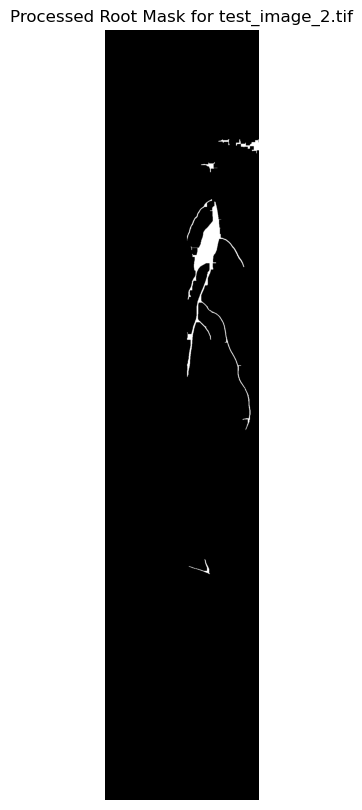

Plant ID: test_image_2_plant_1, Length: 1039.2173875177025


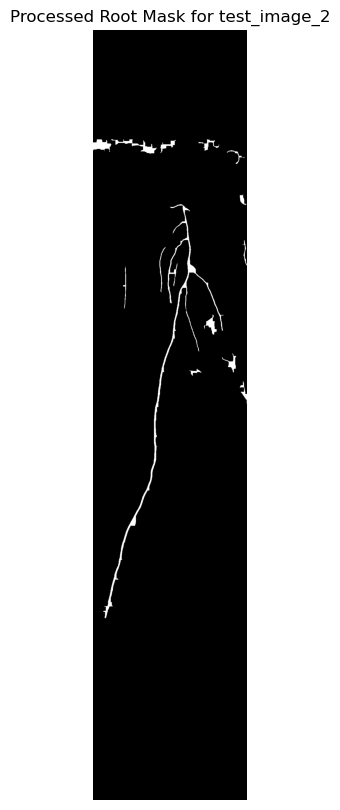

Plant ID: test_image_2_plant_2, Length: 1823.7859300126277


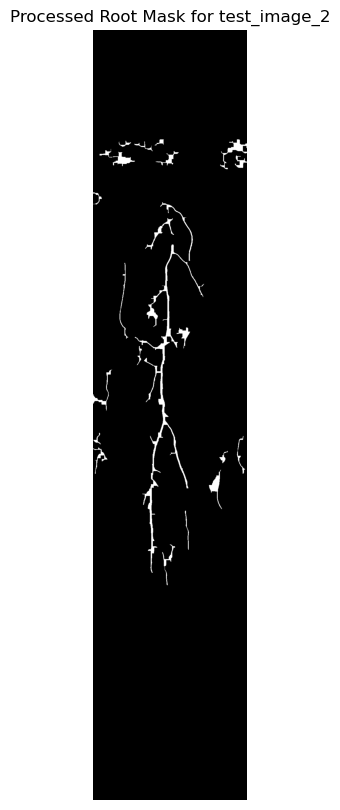

Plant ID: test_image_2_plant_3, Length: 1492.2935059634515


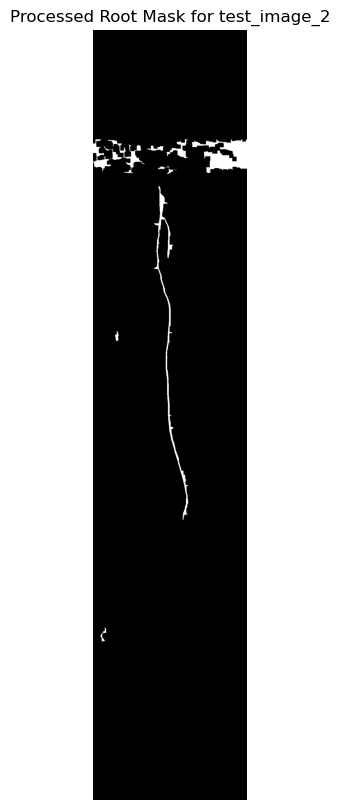

Plant ID: test_image_2_plant_4, Length: 1347.185858225127


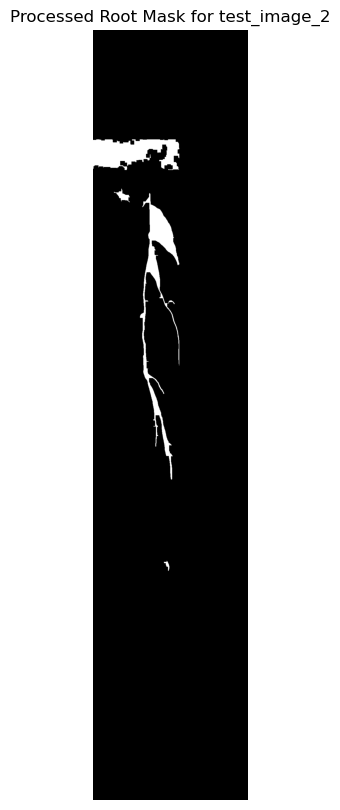

Plant ID: test_image_2_plant_5, Length: 1254.097546470558
(2816, 2816)
4/4 [==============================] - 1s 179ms/step


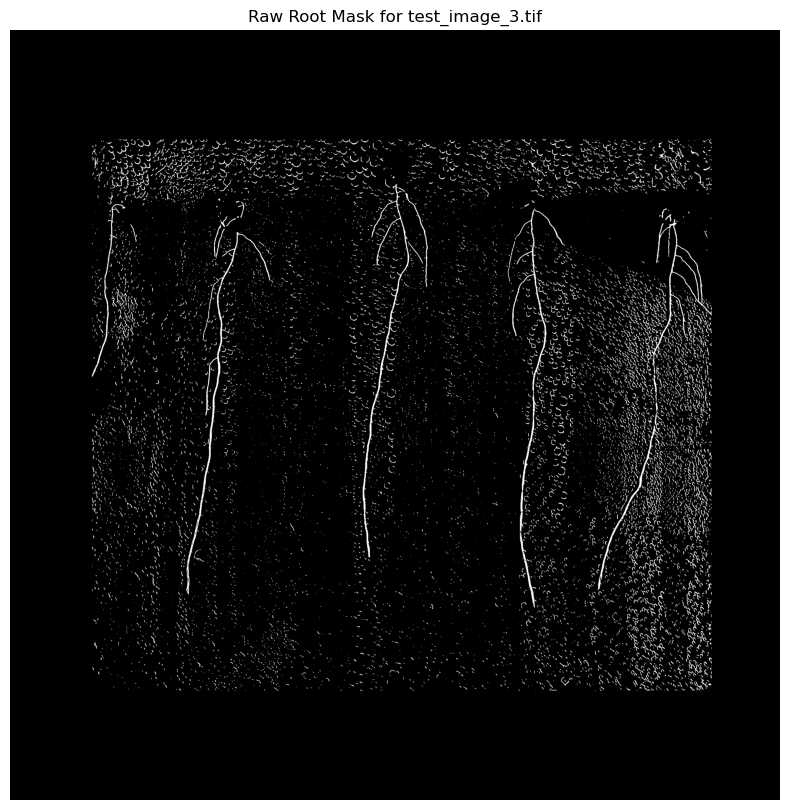

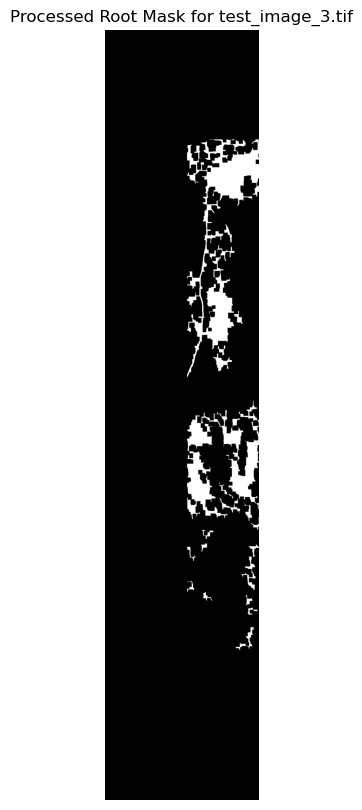

Plant ID: test_image_3_plant_1, Length: 1436.7321061434648


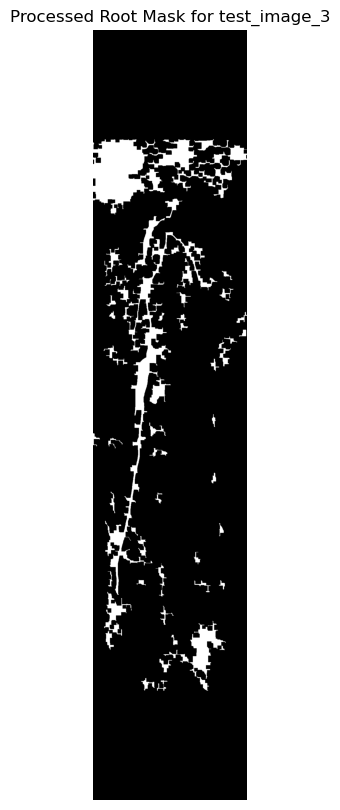

Plant ID: test_image_3_plant_2, Length: 1862.1290757631346


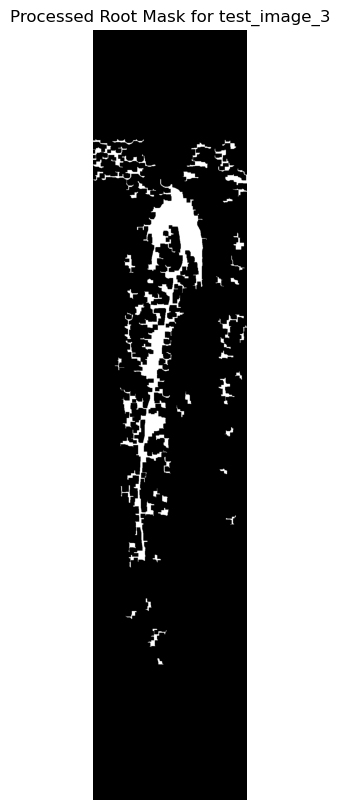

Plant ID: test_image_3_plant_3, Length: 1867.2539674441625


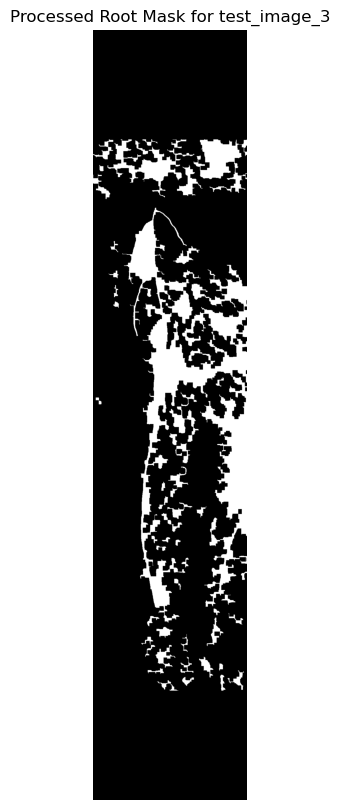

Plant ID: test_image_3_plant_4, Length: 2425.018469431979


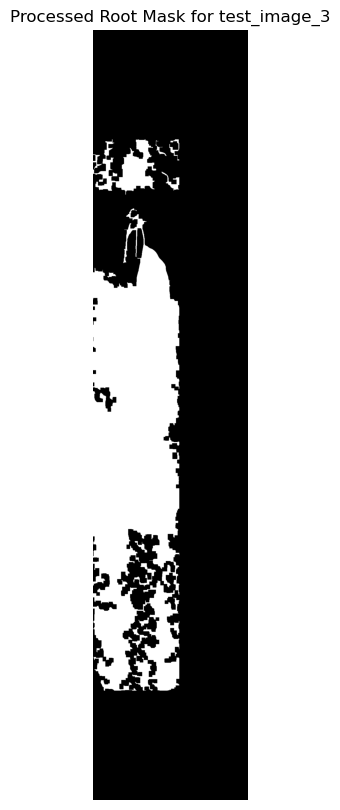

Plant ID: test_image_3_plant_5, Length: 2448.3981951089463
(2816, 2816)
4/4 [==============================] - 1s 196ms/step


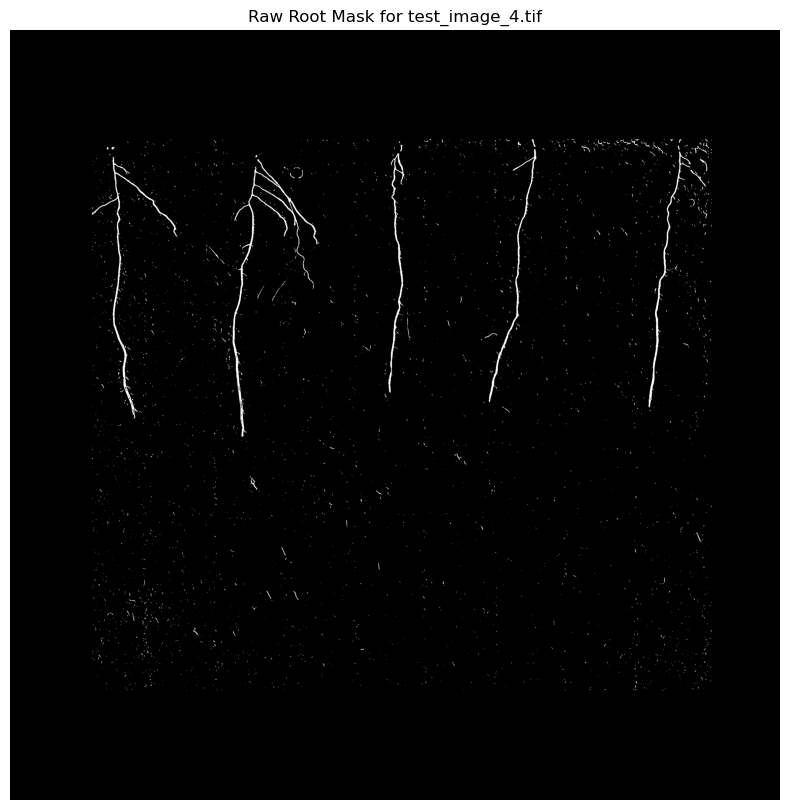

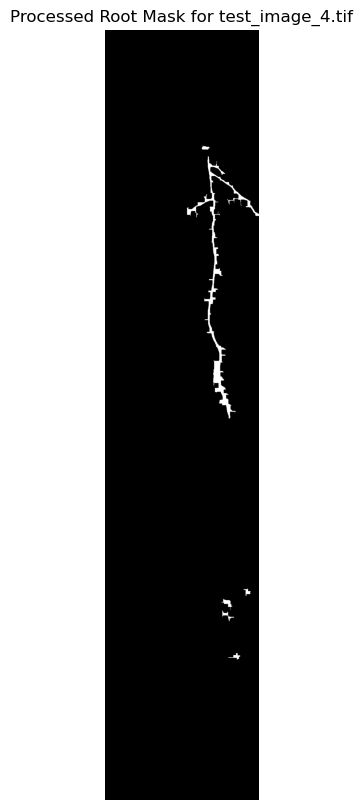

Plant ID: test_image_4_plant_1, Length: 1255.3523804664972


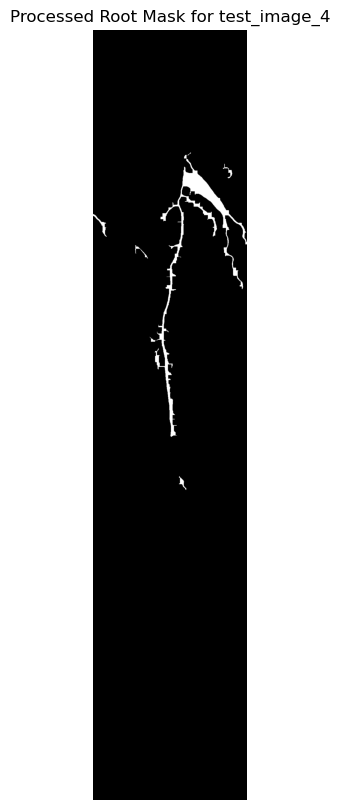

Plant ID: test_image_4_plant_2, Length: 1556.7026688919411


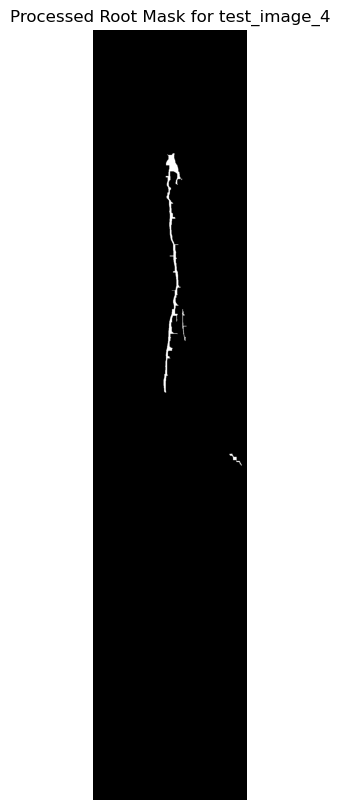

Plant ID: test_image_4_plant_3, Length: 958.0609665440986


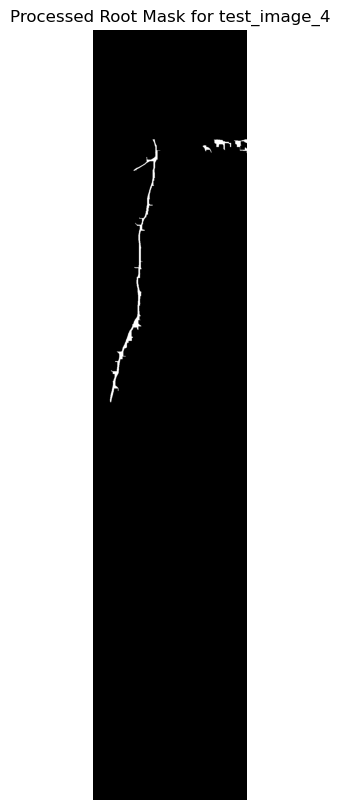

Plant ID: test_image_4_plant_4, Length: 1070.085353161738


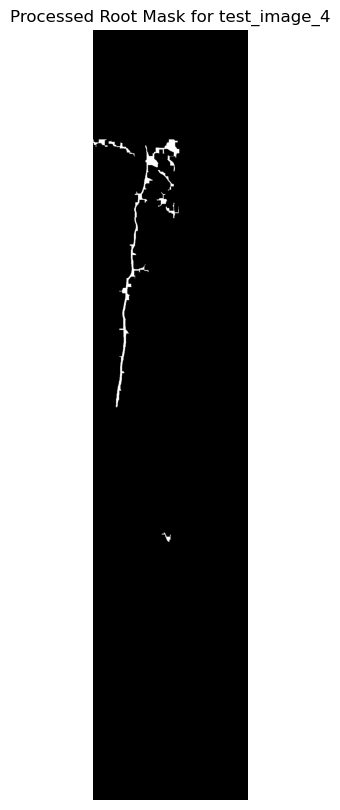

Plant ID: test_image_4_plant_5, Length: 1236.0681092190348
(2816, 2816)
4/4 [==============================] - 1s 241ms/step


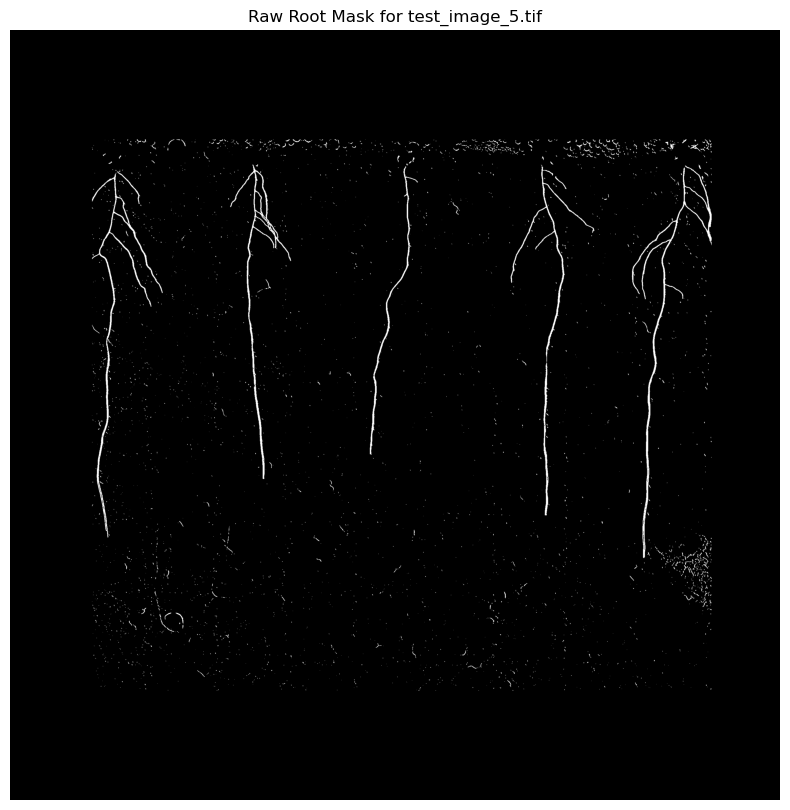

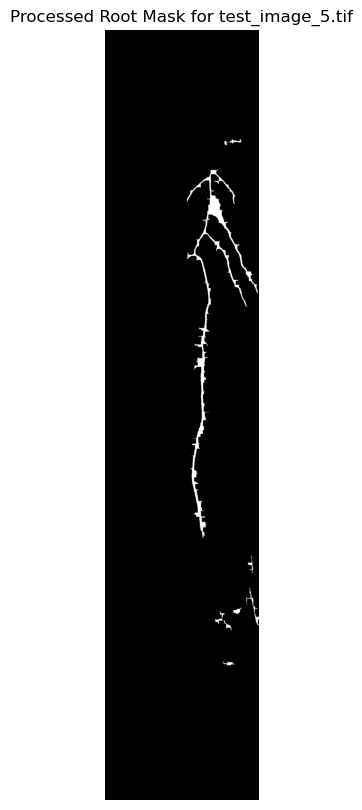

Plant ID: test_image_5_plant_1, Length: 1728.8864350760155


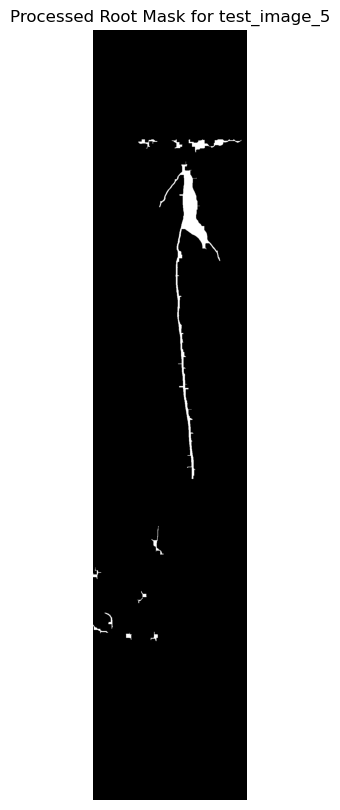

Plant ID: test_image_5_plant_2, Length: 1370.298556597335


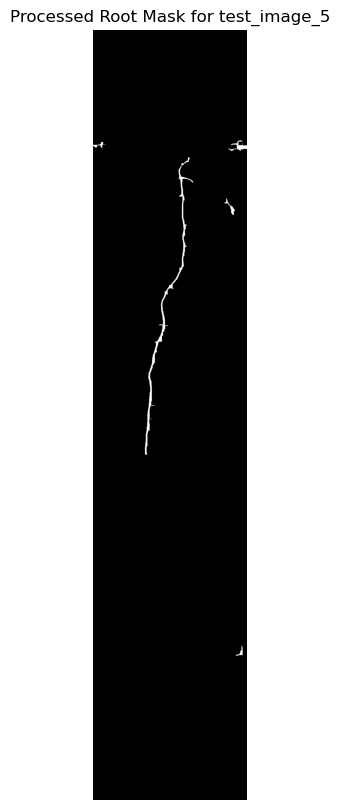

Plant ID: test_image_5_plant_3, Length: 1206.0559159102154


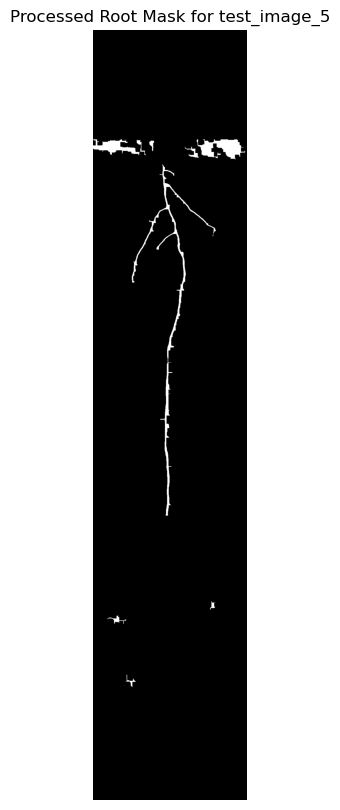

Plant ID: test_image_5_plant_4, Length: 1578.0630585851527


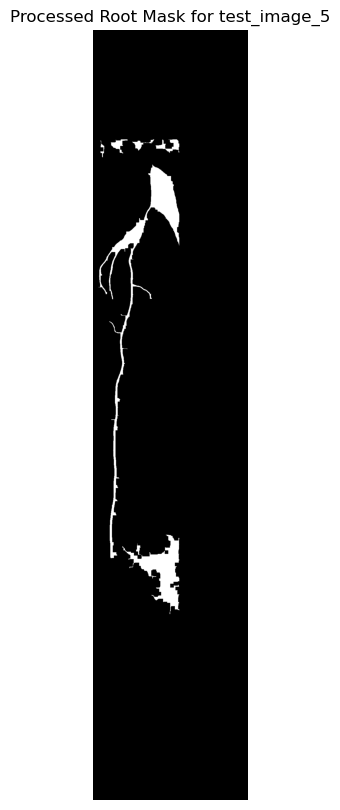

Plant ID: test_image_5_plant_5, Length: 1656.9919907732863
(2816, 2816)
4/4 [==============================] - 1s 194ms/step


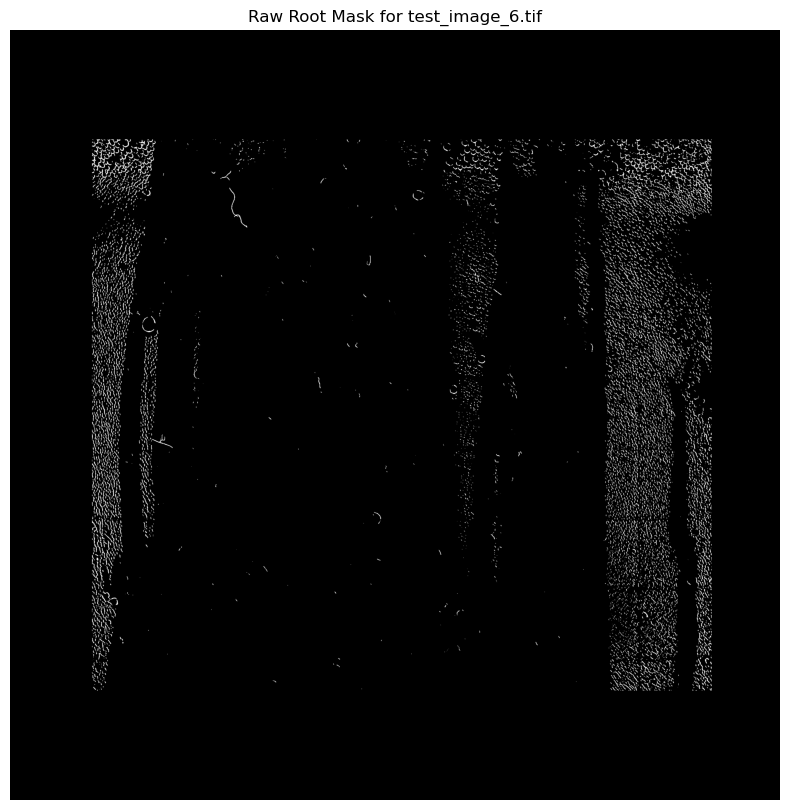

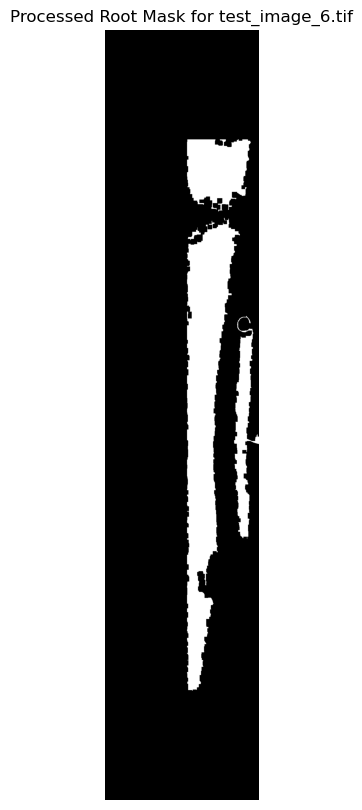

Plant ID: test_image_6_plant_1, Length: 1852.742207411231


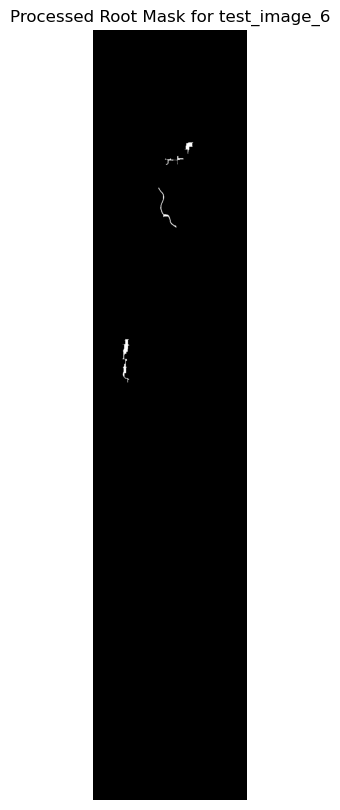

Plant ID: test_image_6_plant_2, Length: 187.75230867899728


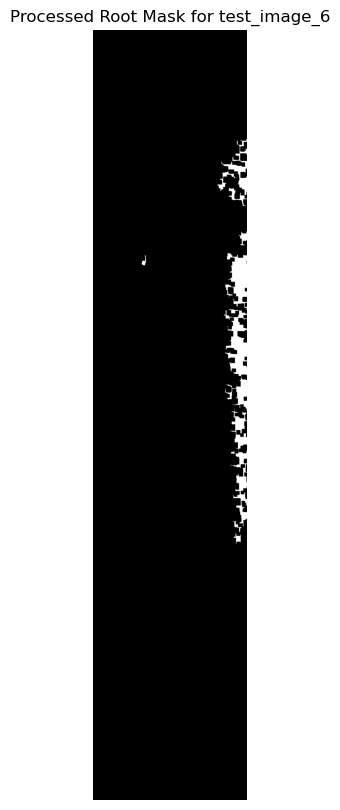

Plant ID: test_image_6_plant_3, Length: 516.1909088590099


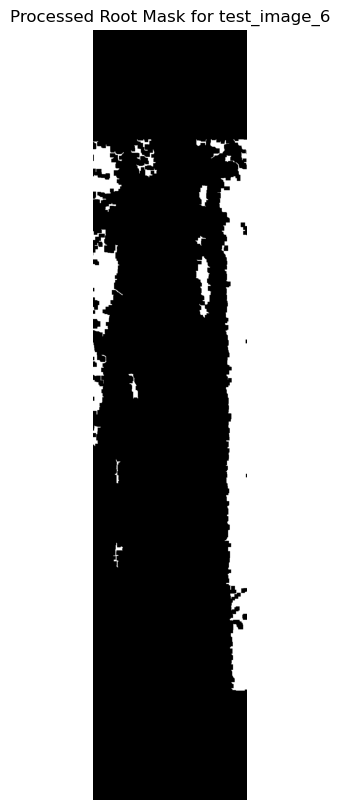

Plant ID: test_image_6_plant_4, Length: 2184.2224381515857


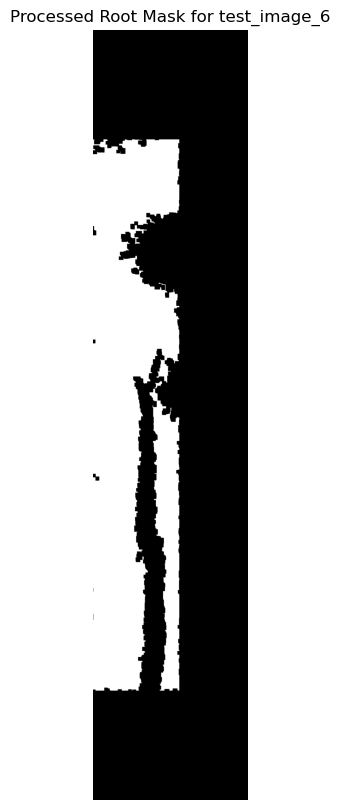

Plant ID: test_image_6_plant_5, Length: 2334.212336883819
(2816, 2816)
4/4 [==============================] - 1s 210ms/step


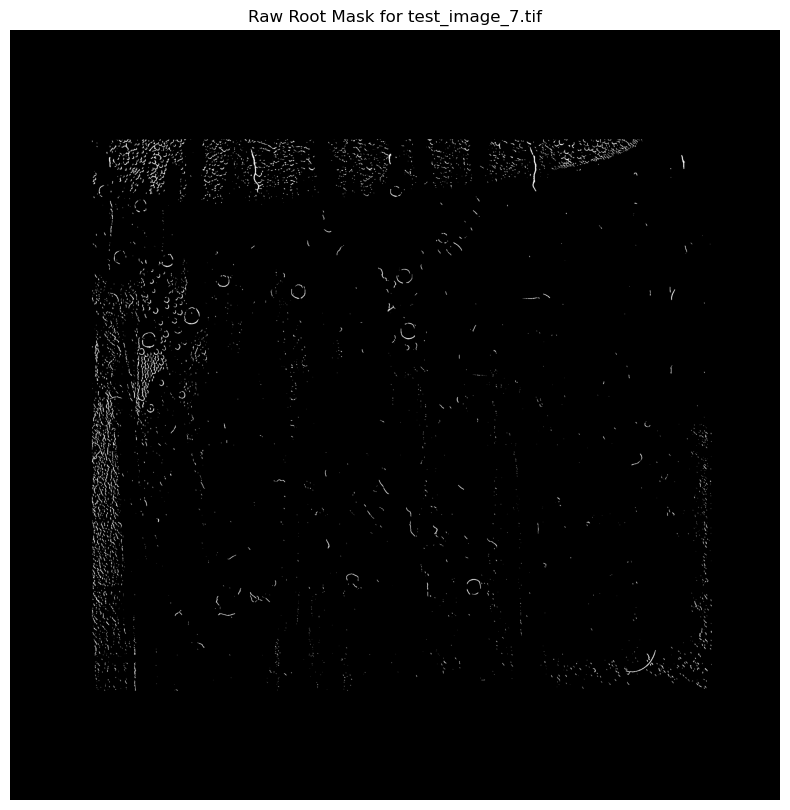

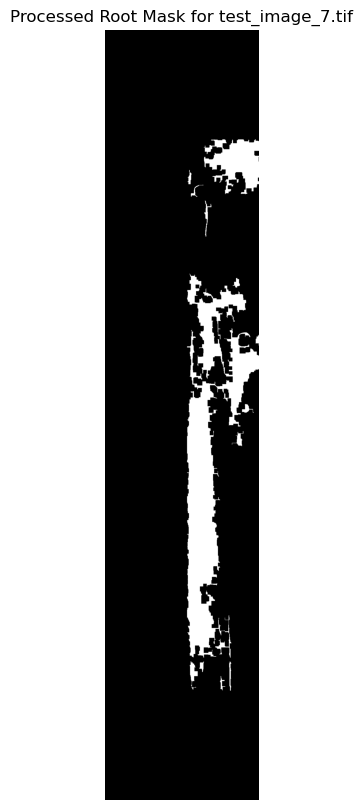

Plant ID: test_image_7_plant_1, Length: 1818.9503602129446


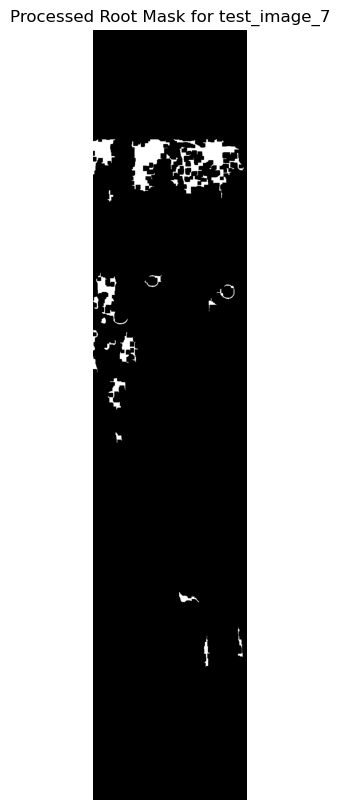

Plant ID: test_image_7_plant_2, Length: 554.9898987322333


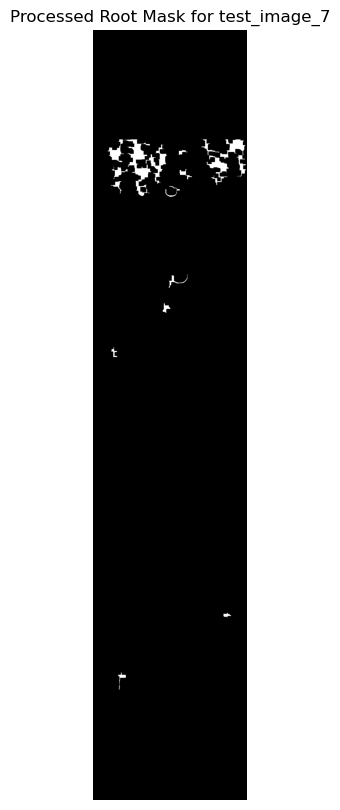

Plant ID: test_image_7_plant_3, Length: 451.14927829866735


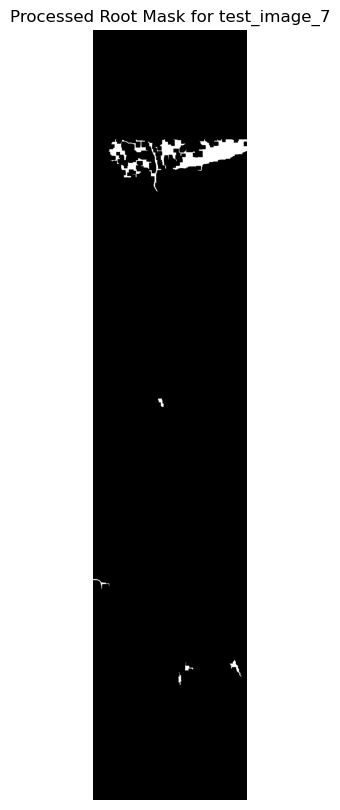

Plant ID: test_image_7_plant_4, Length: 475.3208511739212


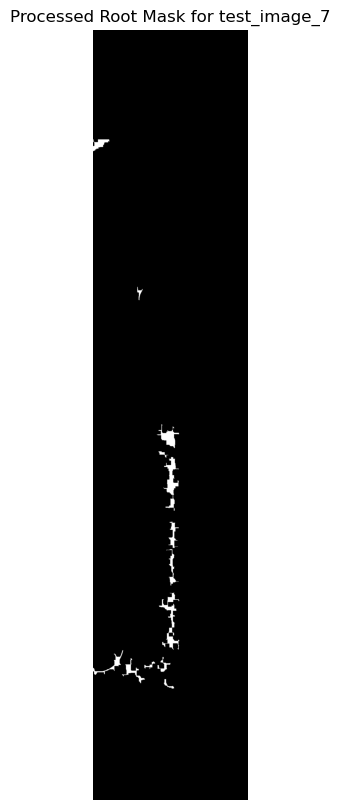

Plant ID: test_image_7_plant_5, Length: 296.3380951166243
(2816, 2816)
4/4 [==============================] - 1s 177ms/step


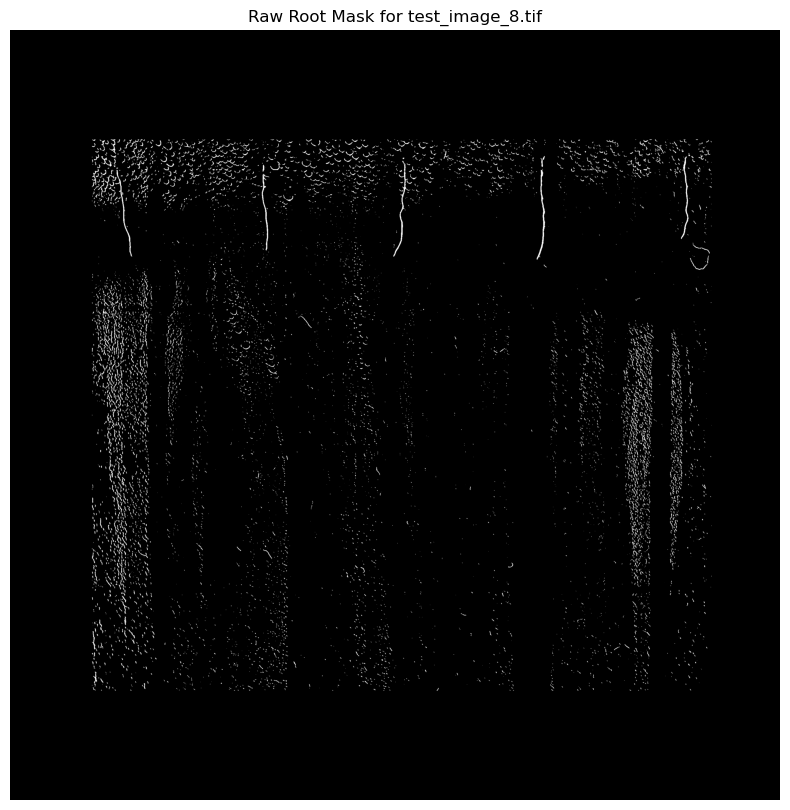

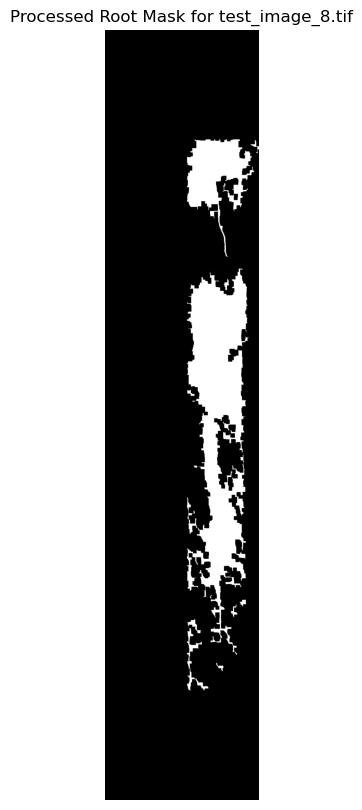

Plant ID: test_image_8_plant_1, Length: 1633.0752518939717


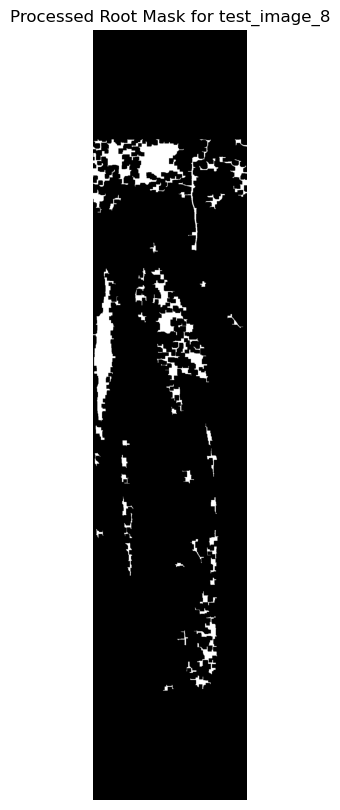

Plant ID: test_image_8_plant_2, Length: 679.1858582251265


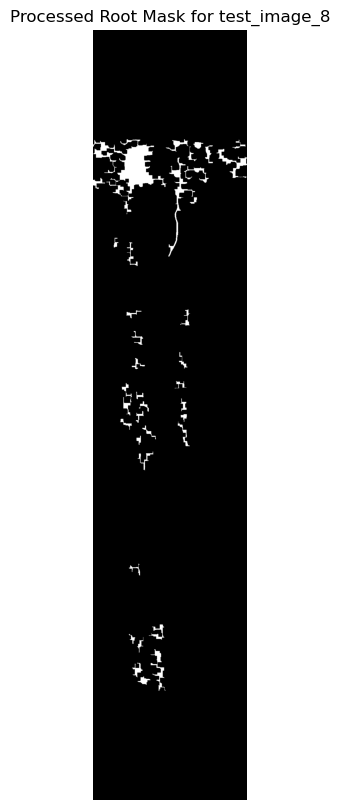

Plant ID: test_image_8_plant_3, Length: 523.4041122946063


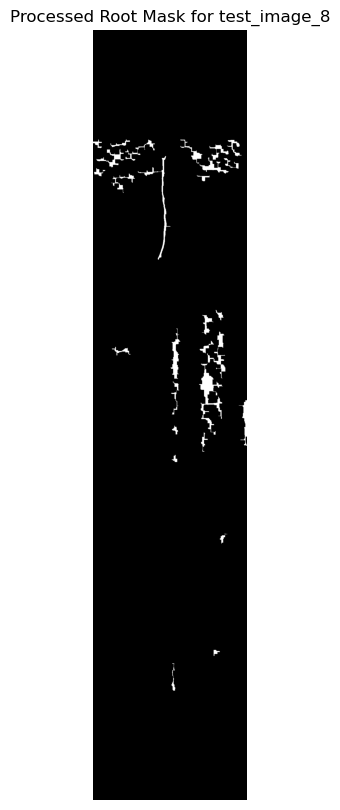

Plant ID: test_image_8_plant_4, Length: 436.3675323681472


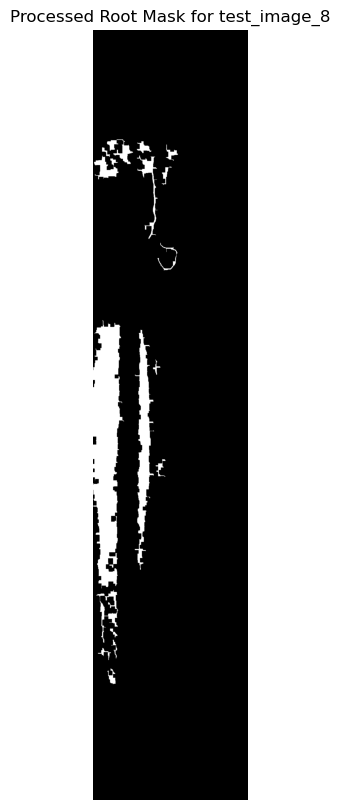

Plant ID: test_image_8_plant_5, Length: 1081.5168106668145
(2816, 2816)
4/4 [==============================] - 1s 185ms/step


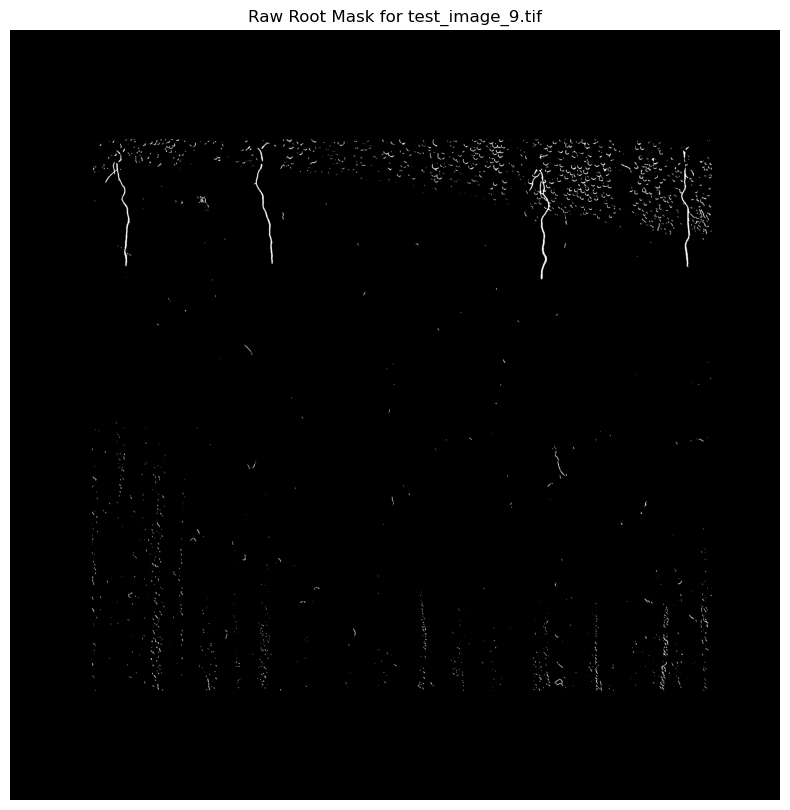

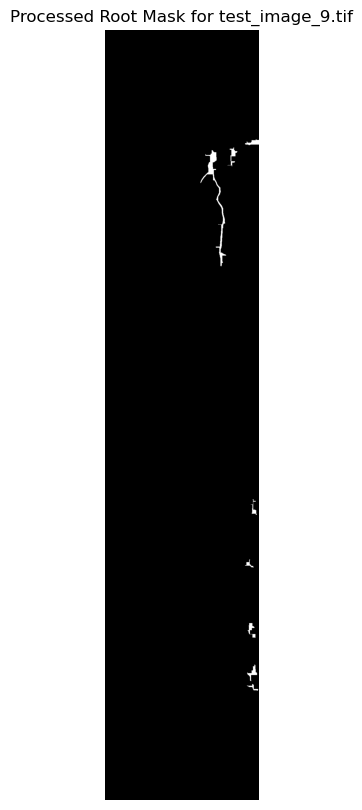

Plant ID: test_image_9_plant_1, Length: 471.663996924429


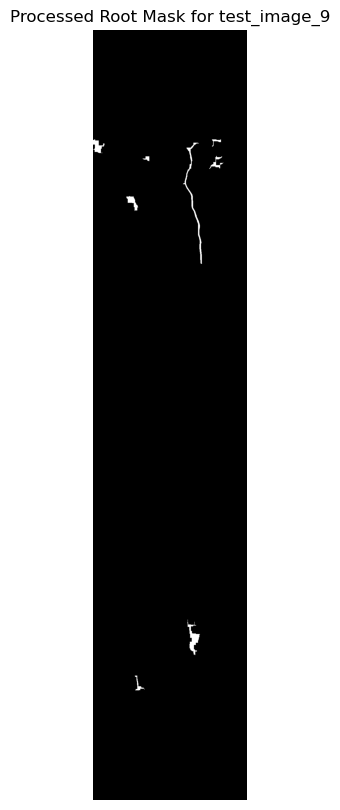

Plant ID: test_image_9_plant_2, Length: 505.5634918610407


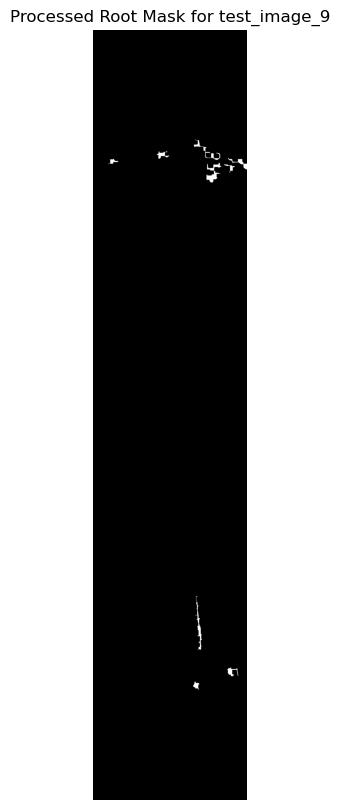

Plant ID: test_image_9_plant_3, Length: 213.52691193458122


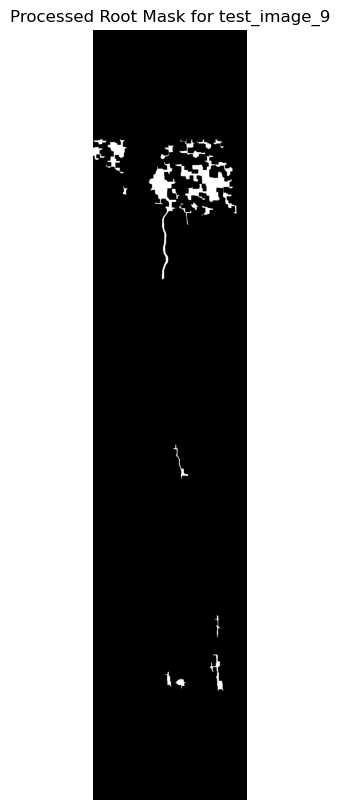

Plant ID: test_image_9_plant_4, Length: 516.948268171891


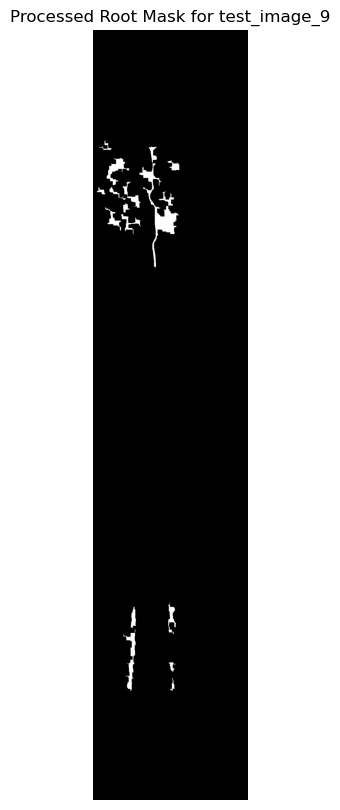

Plant ID: test_image_9_plant_5, Length: 517.9188309203678
Pipeline completed. Results saved to submission_2_retake.csv
       Length (px)
count    55.000000
mean   1138.279143
std     611.595284
min     168.568542
25%     537.835570
50%    1081.516811
75%    1567.382864
max    2448.398195


In [ ]:
# Updated main pipeline function
def run_pipeline(input_dir, model, output_csv_path, patch_size=256):
    # List to store results
    results = []
    # Loop through the images in the input directory
    for image_filename in os.listdir(input_dir):
        image_path = os.path.join(input_dir, image_filename)

        # Step 1: Crop the Petri dish (ROI)
        cropped_image = petri_dish_crop(image_path)
        # Step 2: Pad the cropped image to the patch size
        padded_image = padder(cropped_image, patch_size)
        # Step 3: Patchify the padded image for model use
        img_patches = patchify(padded_image, (patch_size, patch_size), step=patch_size)
        # Reshape the patches to feed into the model
        expected_shape = (
            padded_image.shape[0] // patch_size,
            padded_image.shape[1] // patch_size,
        )
        img_patches = img_patches.reshape(-1, patch_size, patch_size)
        # Step 4: Generate root mask from the patch using U-Net model
        root_mask = model.predict(img_patches)
        # Step 5: Unpatchify the root masks to the original image size
        root_mask = root_mask.reshape(
            expected_shape[0], expected_shape[1], patch_size, patch_size
        )
        root_mask = unpatchify(root_mask, padded_image.shape[:2])
        # Add padding to the root mask to handle edge artifacts
        root_mask[:, :300] = 0  # Remove left edge
        root_mask[:, -250:] = 0  # Remove right edge
        root_mask[:400, :] = 0  # Remove top edge
        root_mask[-400:, :] = 0  # Remove bottom edge

        plt.figure(figsize=(10, 10))
        plt.imshow(root_mask, cmap="gray")
        plt.title(f"Raw Root Mask for {image_filename}")
        plt.axis("off")
        plt.show()

        root_mask = refine_mask(root_mask)
        # Step 6: Extract RSA from the root mask
        roots = extract_rsa(root_mask)

        # Step 7: Measure root lengths and extract data using the new function
        for i, root in enumerate(roots):
            root = np.array(root, dtype=np.uint8)  # Ensure binary input
            branch_data, G, longest_path, longest_path_len = measure_root(root)

            plt.figure(figsize=(10, 10))
            plt.imshow(root, cmap="gray")
            plt.title(f"Processed Root Mask for {image_filename}")
            plt.axis("off")
            plt.show()

            image_filename = os.path.splitext(image_filename)[0]
            customed_image_filename = f"{image_filename}_plant_{i+1}"

            print(f"Plant ID: {customed_image_filename}, Length: {longest_path_len}")

            results.append(
                {"Plant ID": customed_image_filename, "Length (px)": longest_path_len}
            )

    # Create DataFrame from the results and save it as a CSV file
    df = pd.DataFrame(results)
    df.set_index("Plant ID", inplace=True)
    df.to_csv(output_csv_path, index=True)
    print(f"Pipeline completed. Results saved to {output_csv_path}")
    print(df.describe())


# Path to your trained U-Net model from Task 5
model_path = r"D:\YearTwoAI\Block B\2024-25b-fai2-adsai-VictoriaVicheva233182\datalab_tasks\task 8\victoria_233182_unet_model_Best_256px.h5"
model = load_unet_model(model_path)

# Input directory for raw images
input_dir = r"D:\YearTwoAI\Block B\2024-25b-fai2-adsai-VictoriaVicheva233182\datalab_tasks\task 8\kaggle"

# Output path for the CSV file
output_csv_path = "submission_3_retake.csv"

run_pipeline(input_dir, model, output_csv_path)